In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re

# from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# nltk.download('stopwords')


In [55]:
df_8label = pd.read_csv("SC_Vuln_8label.csv", index_col=0)
print(df_8label.head())
print(df_8label.isnull().sum()) #no missing values

    filename                                               code  \
0  33790.sol  pragma solidity ^0.4.4;\r\n\r\ncontract Token ...   
1  31454.sol  pragma solidity ^0.4.4;\r\n\r\ncontract Token ...   
2  40744.sol  contract SendBalance {\r\n mapping (address =>...   
3  39290.sol  /**\r\n * Originally from https://github.com/C...   
4  39358.sol  pragma solidity ^0.4.4;\r\n\r\nlibrary ArrayLi...   

                        label  label_encoded  
0  ./Dataset/reentrancy (RE)/              5  
1  ./Dataset/reentrancy (RE)/              5  
2  ./Dataset/reentrancy (RE)/              5  
3  ./Dataset/reentrancy (RE)/              5  
4  ./Dataset/reentrancy (RE)/              5  
filename         0
code             0
label            0
label_encoded    0
dtype: int64


In [56]:
import numpy as np
import pandas as pd
from datasets import load_dataset

ds = load_dataset("mwritescode/slither-audited-smart-contracts", "all-multilabel", trust_remote_code=True)

df = ds['train'].to_pandas()
df['slither'] = df['slither'].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

safe_contracts = df[df['slither'].apply(lambda x: x == [4])]
safe_contracts_final = pd.DataFrame({
    'filename': safe_contracts['address'],
    'code': safe_contracts['source_code'],
    'label': "No Vulnerability",
    'label_encoded': 8, 
})

safe_contracts_final.to_csv("safe_contracts.csv", index=False)


In [57]:
print(safe_contracts_final.head())

                                       filename  \
0    0x006699d34AA3013605d468d2755A2Fe59A16B12B   
56   0x13ea09ea5107af214a6fa279ac20c229ee188b28   
115  0x2742A152Be5032DafBC885Ba1801ffbc2345de7B   
126  0x29d37c358bff8c7facbeba406c6b5057322fc7f4   
218  0x4639cd8cd52ec1cf2e496a606ce28d8afb1c792f   

                                                  code             label  \
0    pragma solidity 0.5.4;\n\ninterface IERC20 {\n...  No Vulnerability   
56   pragma solidity 0.5.17;\n\ncontract InterestRa...  No Vulnerability   
115  pragma solidity 0.5.15;\n\ncontract IFactRegis...  No Vulnerability   
126  pragma solidity 0.5.17;\n\ninterface IERC20 {\...  No Vulnerability   
218  pragma solidity 0.6.12;\n\nabstract contract E...  No Vulnerability   

     label_encoded  
0                8  
56               8  
115              8  
126              8  
218              8  


In [58]:
safe_contracts_code = safe_contracts_final.drop_duplicates(subset='filename', keep='first')

#combine the two datasets
combined_data = pd.concat([df_8label, safe_contracts_code], ignore_index=True)
# combined_data.to_csv("combined_dataset.csv", index=False)

# combined_data.to_csv("combined_dataset.csv", index=False)

In [59]:


# Define vulnerability labels
labels = [
    "./Dataset/block number dependency (BN)",
    "./Dataset/dangerous delegatecall (DE)/",
    "./Dataset/ether frozen (EF)",
    "./Dataset/ether strict equality (SE)",
    "./Dataset/integer overflow (OF)/",
    "./Dataset/reentrancy (RE)/",
    "./Dataset/timestamp dependency (TP)/",
    "./Dataset/unchecked external call (UC)"
]

# Create a mapping dictionary for easy retrieval
vulnerability_map = {0: "No Vulnerability"}  # First index is for no vulnerability
for i, label in enumerate(labels, start=1):
    vulnerability_map[i] = label

# Save mapping as a JSON file
with open("vulnerability_map.json", "w") as f:
    json.dump(vulnerability_map, f, indent=4)

# Create 8 vulnerability columns with default 0
for label in labels:
    combined_data[label] = 0

# Update labels based on the 'label' column
for index, row in combined_data.iterrows():
    if row["label"] in labels:
        combined_data.at[index, row["label"]] = 1  # Mark as vulnerable

# Drop old 'label' and 'label_encoded' columns
combined_data = combined_data.drop(columns=["label", "label_encoded"])

# Aggregate data by filename and code, ensuring a single row per file
combined_data = combined_data.groupby(["filename", "code"], as_index=False).max()

# Convert vulnerability columns into a list representation
combined_data["vulnerability_list"] = combined_data[labels].apply(lambda x: [1 if sum(x) == 0 else 0] + x.tolist(), axis=1)

# Drop the individual vulnerability columns
combined_data = combined_data.drop(columns=labels)

# Save the processed dataset
combined_data.to_csv("combined_dataset_processed.csv", index=False)

print("Saved processed dataset as 'combined_dataset_processed.csv'.")
print("Saved vulnerability mapping as 'vulnerability_map.json'.")


Saved processed dataset as 'combined_dataset_processed.csv'.
Saved vulnerability mapping as 'vulnerability_map.json'.


In [60]:
# Example of Retrieve Vulnerability Names

# Load the mapping
with open("vulnerability_map.json", "r") as f:
    vulnerability_map = json.load(f)

print(vulnerability_map["0"])
print(vulnerability_map["2"])  
print(vulnerability_map["3"])

# or




# Convert keys to integers (optional, but recommended)
vulnerability_map = {int(k): v for k, v in vulnerability_map.items()}

print(vulnerability_map[1])
print(vulnerability_map[5])  
print(vulnerability_map[6])

No Vulnerability
./Dataset/dangerous delegatecall (DE)/
./Dataset/ether frozen (EF)
./Dataset/block number dependency (BN)
./Dataset/integer overflow (OF)/
./Dataset/reentrancy (RE)/


 Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6547 entries, 0 to 6546
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   filename            6547 non-null   object
 1   code                6547 non-null   object
 2   vulnerability_list  6547 non-null   object
dtypes: object(3)
memory usage: 153.6+ KB
None

 Missing Value Statistics:
 filename              0
code                  0
vulnerability_list    0
dtype: int64

 Total Rows in Dataset: 6547

 Unique Filenames: 6496

 Vulnerability Label Distribution:
                             Vulnerability  Count
0                        No Vulnerability   3507
1  ./Dataset/block number dependency (BN)    406
2  ./Dataset/dangerous delegatecall (DE)/     97
3             ./Dataset/ether frozen (EF)     97
4    ./Dataset/ether strict equality (SE)    366
5        ./Dataset/integer overflow (OF)/    590
6              ./Dataset/reentrancy (RE

C:\Users\FLZ\AppData\Local\Temp\ipykernel_18252\2605950059.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Vulnerability", y="Count", data=vulnerability_df, palette="viridis")


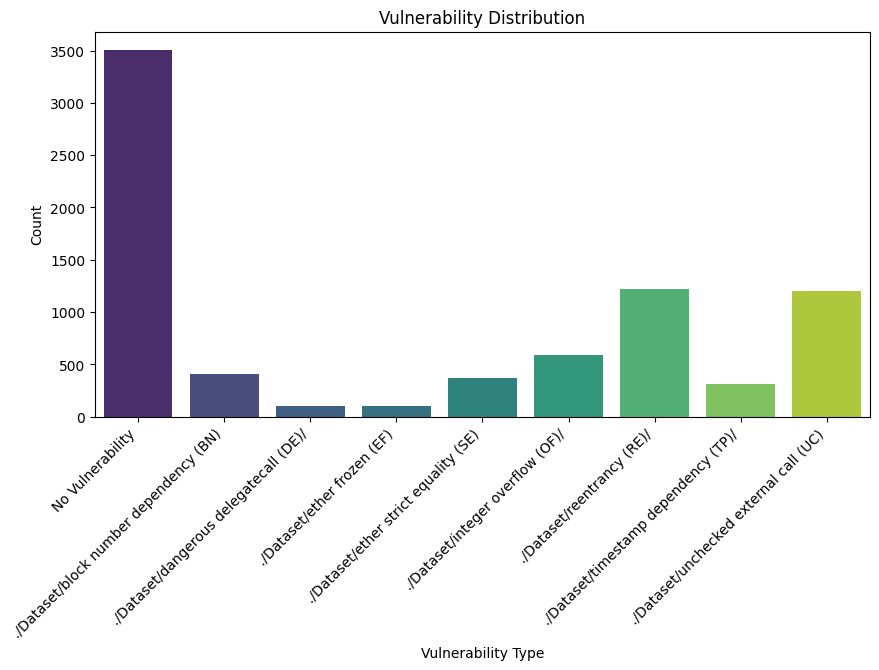

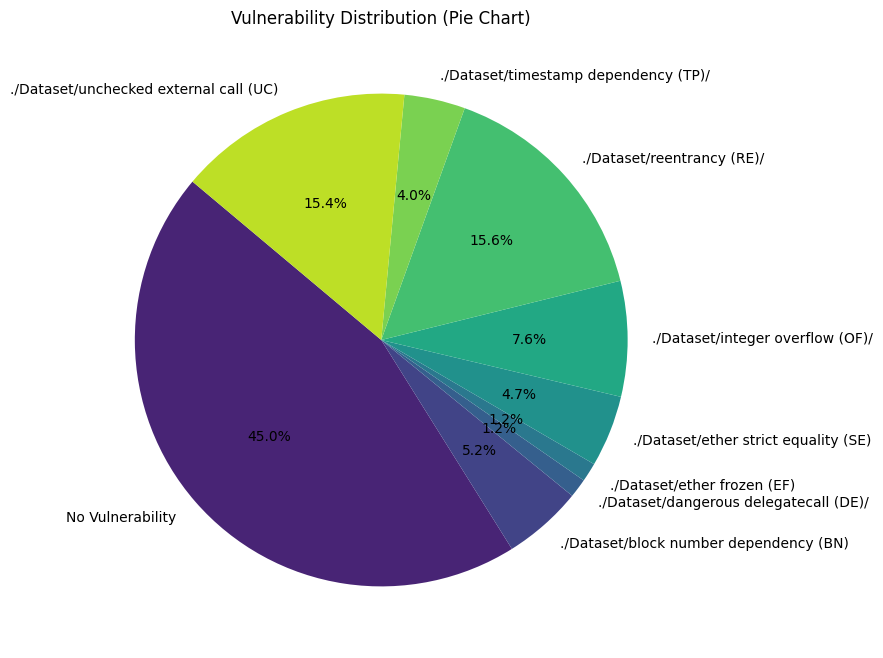

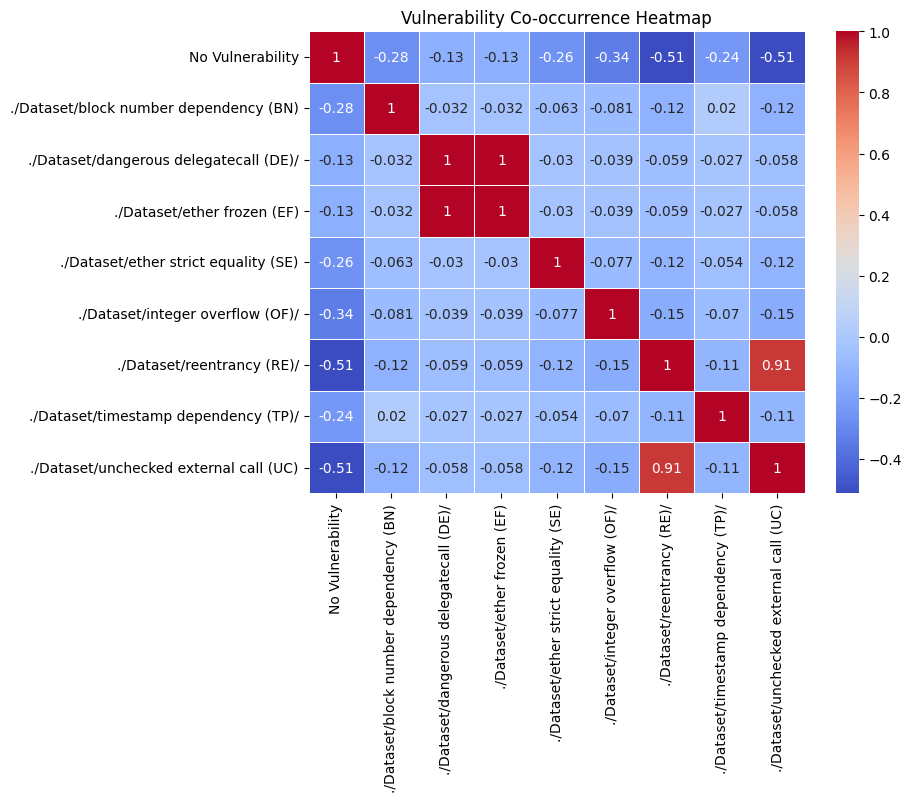

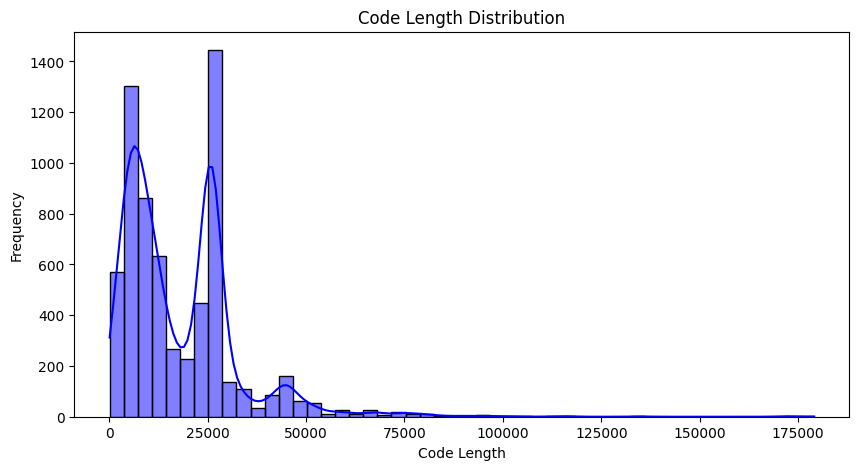

In [67]:
import pandas as pd
import json  # To load the mapping
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("combined_dataset_processed.csv")

# Load vulnerability map
with open("vulnerability_map.json", "r") as f:
    vulnerability_map = json.load(f)
    vulnerability_map = {int(k): v for k, v in vulnerability_map.items()}  # Convert keys to integers

### === 1 Basic Dataset Information === ###
print(" Dataset Overview:")
print(df.info())   # Data types & missing values
print("\n Missing Value Statistics:\n", df.isnull().sum())
print("\n Total Rows in Dataset:", df.shape[0])

# Check if filenames are unique
print("\n Unique Filenames:", df["filename"].nunique())

# Convert string representation of list to actual list
df["vulnerability_list"] = df["vulnerability_list"].apply(lambda x: eval(x) if isinstance(x, str) else x)

# Count vulnerabilities
vulnerability_counts = [0] * len(vulnerability_map)
for row in df["vulnerability_list"]:
    for i, presence in enumerate(row):
        vulnerability_counts[i] += presence

# Convert counts to DataFrame for visualization
vulnerability_df = pd.DataFrame(
    {"Vulnerability": [vulnerability_map[i] for i in range(len(vulnerability_map))], "Count": vulnerability_counts}
)

print("\n Vulnerability Label Distribution:\n", vulnerability_df)

### === 2 Label Distribution Visualization === ###
plt.figure(figsize=(10,5))
sns.barplot(x="Vulnerability", y="Count", data=vulnerability_df, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Vulnerability Type")
plt.ylabel("Count")
plt.title("Vulnerability Distribution")
plt.show()

### === 3 Pie Chart for Vulnerability Distribution === ###
plt.figure(figsize=(8, 8))
plt.pie(
    vulnerability_df["Count"], 
    labels=vulnerability_df["Vulnerability"], 
    autopct="%1.1f%%", 
    colors=sns.color_palette("viridis", len(vulnerability_df)), 
    startangle=140
)
plt.title("Vulnerability Distribution (Pie Chart)")
plt.show()

### === 4 Co-occurrence Analysis (Heatmap) === ###
# Convert list format back into a DataFrame with separate columns for each vulnerability
vulnerability_matrix = pd.DataFrame(df["vulnerability_list"].to_list(), columns=vulnerability_map.values())

plt.figure(figsize=(8,6))
sns.heatmap(vulnerability_matrix.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Vulnerability Co-occurrence Heatmap")
plt.show()

### === 5 Code Length Distribution === ###
# Compute code length
df["code_length"] = df["code"].apply(lambda x: len(str(x)))

# Plot histogram
plt.figure(figsize=(10, 5))
sns.histplot(df["code_length"], bins=50, kde=True, color="blue")
plt.xlabel("Code Length")
plt.ylabel("Frequency")
plt.title("Code Length Distribution")
plt.show()


In [68]:
# solidity_stopwords = [
#     "pragma", "interface", "contract", "function", "event", "modifier", "library", "using",
#     "string", "uint8", "uint256", "address", "mapping", "bool", "require", "return", "memory",
#     "storage", "public", "internal", "view", "constant", "constructor",
#     "_owner", "_balances", "_allowances", "_founder", "_marketing", "_who", "_burntAmount",
#     "_from", "_to", "_value", "_timestamp", "_bool", "msg.sender", "totalSupply",
#     "balanceOf", "transfer", "allowance", "approve", "transferFrom", "add", "sub", "mul", "div",
#     "mod", "changeFounder", "setMinter", "setFurnace", "freezeAccount", "solidity", "bytes32"
# ]

def clean_code(code):
    # Remove comments (single-line and multi-line)
    code = re.sub(r'\/\/.*', '', code)
    code = re.sub(r'\/\*[\s\S]*?\*\/', '', code)
    code = re.sub(r"pragma solidity[^;]+;", "", code)
    code = re.sub(r"import [^;]+;", "", code)
    code = re.sub(r"\s+", " ", code).strip()

    string_literals = re.findall(r'"[^"]*"|\'[^\']*\'', code)
    string_map = {s: f'__STRING{idx}__' for idx, s in enumerate(string_literals)}
    for string, placeholder in string_map.items():
        code = code.replace(string, placeholder)
    
    return code
    
# def clean_code(solidity_code):
#     cleaned_code = re.sub(r'//.*?$', '', solidity_code, flags=re.MULTILINE)
#     cleaned_code = re.sub(r'/\*.*?\*/', '', cleaned_code, flags=re.DOTALL)
#     cleaned_code = re.sub(r'[^a-zA-Z0-9\s+=\-*&|/<>!(){};.,]', '', cleaned_code)
#     cleaned_code = '\n'.join(line.strip().lower() for line in cleaned_code.splitlines() if line.strip())

#     stop_words = set(stopwords.words('english'))
#     tokens = [word for word in cleaned_code.split() if word not in stop_words]
#     tokens = [token for token in tokens if token not in solidity_stopwords]

#     return tokens


df['clean_code'] = df['code'].apply(clean_code)
print(df['clean_code'])


0       contract BREBuy { struct ContractParam { uint3...
1       abstract contract Context { function _msgSende...
2       interface IERC20 { function totalSupply() exte...
3       abstract contract Context { function _msgSende...
4       abstract contract Context { function _msgSende...
                              ...                        
6542    contract RP1events { event onNewName ( uint256...
6543    library SafeMath { function mul(uint256 a, uin...
6544    library SafeMath { function mul(uint256 _a, ui...
6545    library SafeMath { function mul(uint256 a, uin...
6546    library SafeMath { function mul(uint256 a, uin...
Name: clean_code, Length: 6547, dtype: object


In [69]:
#Tokenization helps extract important elements from the code
solidity_token_pattern = r"""
    [A-Za-z_][A-Za-z_0-9]*      
    |\d+\.\d+|\d+               
    |0x[0-9a-fA-F]+             
    |\d+e[+-]?\d+              
    |==|!=|>=|<=|\+=|-=|\*=|/=  
    |=>|=<|>>|<<|\+\+|--        
    |&&|\|\||!                  
    |[^\w\s]                    
"""

tokenizer = RegexpTokenizer(solidity_token_pattern, flags=re.VERBOSE)

df['tokens'] = df['clean_code'].apply(tokenizer.tokenize)
print(df['tokens'][0])

['contract', 'BREBuy', '{', 'struct', 'ContractParam', '{', 'uint32', 'totalSize', ';', 'uint256', 'singlePrice', ';', 'uint8', 'pumpRate', ';', 'bool', 'hasChange', ';', '}', 'address', 'owner', '=', '0', 'x0', ';', 'uint32', 'gameIndex', '=', '0', ';', 'uint256', 'totalPrice', '=', '0', ';', 'bool', 'isLock', '=', 'false', ';', 'ContractParam', 'public', 'setConfig', ';', 'ContractParam', 'public', 'curConfig', ';', 'address', '[', ']', 'public', 'addressArray', '=', 'new', 'address', '[', ']', '(', '0', ')', ';', 'event', 'openLockEvent', '(', ')', ';', 'event', 'addPlayerEvent', '(', 'uint32', 'gameIndex', ',', 'address', 'player', ')', ';', 'event', 'gameOverEvent', '(', 'uint32', 'gameIndex', ',', 'uint32', 'totalSize', ',', 'uint256', 'singlePrice', ',', 'uint8', 'pumpRate', ',', 'address', 'winAddr', ',', 'uint', 'overTime', ')', ';', 'event', 'stopGameEvent', '(', 'uint', 'totalBalace', ',', 'uint', 'totalSize', ',', 'uint', 'price', ')', ';', 'constructor', '(', 'uint32', '_t

In [70]:
#Feature Extraction to numerical features for TF-ID, feature matri
df['token_string'] = df['tokens'].apply(lambda x: ' '.join(x))
vectorizer = TfidfVectorizer(max_features=1000) 
X_tfidf = vectorizer.fit_transform(df['token_string'])


In [71]:
# encoder = LabelEncoder()
# df['label_encoded'] = encoder.fit_transform(df['label'])
# print(df['label_encoded'])



# X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['label_encoded'], test_size=0.2, random_state=42, stratify=df['label_encoded'])
# print(y_train.value_counts())
# print(y_test.value_counts())